In [37]:
from pycoral.utils import edgetpu
from pycoral.adapters import common
from PIL import Image
import numpy as np
import time
import os 
import re
import glob 
import tensorflow as tf
import time 

In [13]:
def prepare_input_img(img_path, img_w=128, img_h=128):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
    resize_img = tf.image.resize_with_pad(img, target_height=img_h, target_width=img_w, method='bilinear')
    input_img = tf.expand_dims(resize_img, axis=0)
    return input_img

In [14]:
def quantized_input(input_tensor, input_scale, input_zero_point):
    return tf.cast((input_tensor / input_scale + input_zero_point), tf.uint8)

In [15]:
def dequantized_output(output_tensor, output_scale, output_zero_point):
    return tf.cast(((output_tensor - output_zero_point) * output_scale), tf.float32)

In [16]:
def jaccard_coefficient(y_true, y_pred, smooth=1.):
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    union = tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection
    return (intersection + smooth) / (union + smooth)

In [42]:
def inf_per_img(img_path, interpreter, conf_threshold=0.5):
    # get details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']
    
    # prepare input
    intput_tensor = prepare_input_img(img_path)
    intput_tensor = quantized_input(intput_tensor, input_scale, input_zero_point)
    
    # inf
    interpreter.set_tensor(input_details[0]['index'], intput_tensor)
    interpreter.invoke()
    
    # get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data = dequantized_output(output_data, output_scale, output_zero_point)
    output_data = tf.squeeze(output_data)
    output_data = tf.where(output_data > conf_threshold, 1., 0)
    return output_data

In [43]:
def read_mask(img_path):
    mask_path = re.sub("images", "labels", img_path)
    mask_path = re.sub(".jpg", ".png", mask_path)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, dtype=tf.float32)
    mask = tf.image.resize_with_pad(mask, target_height=128, target_width=128, method='bilinear')
    mask = tf.where(mask > 0, 1., 0)
    return mask

In [44]:
model_path = "/app/seg/jaccard_edgetpu_model_edgetpu.tflite"
interpreter = edgetpu.make_interpreter(model_path)
interpreter.allocate_tensors()

In [46]:
data_dir = "/app/seg/data/images/train"
imgs_path = glob.glob(f"{data_dir}/*.jpg")
score = 0.
imgs_above_80 = 0
for i in range(len(imgs_path)):
    img_path = imgs_path[i]
#     start = time.time()
    output_data = inf_per_img(img_path, interpreter)
#     end = time.time()
#     print(f"inf time: {(end - start) * 1000}ms")
    mask = read_mask(img_path)
    jaccard_score = jaccard_coefficient(mask, output_data)
    if jaccard_score >= 0.8:
        imgs_above_80 += 1
    score += jaccard_score

mean_score = score / len(imgs_path)
above_80 = imgs_above_80 / len(imgs_path)
print(mean_score)
print(above_80)

tf.Tensor(0.8150738, shape=(), dtype=float32)
0.6647173489278753


In [23]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

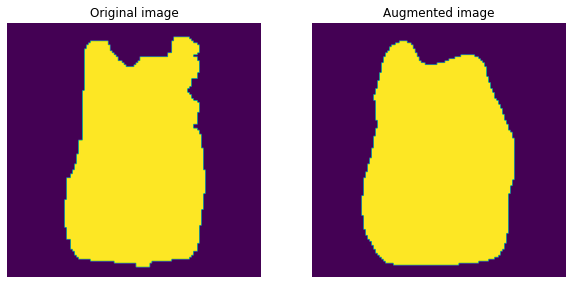

In [27]:
visualize(mask, output_data)